In [1]:
from dfttopif import directory_to_pif
pif = directory_to_pif("/home/maxhutch/science/alloy.pbe/B/B.hR12")

In [2]:
from pypif.util.read_view import ReadView
rv = ReadView(pif)
print(rv.keys())
print(rv.chemical_formula)

dict_keys(['Cutoff Energy', 'Converged', 'Density Functional Theory', 'VASP', 'Psuedopotentials', 'Relaxed', 'XC Functional', 'Total Energy', 'k-Points per Reciprocal Atom', 'Pressure'])
B12


In [3]:
import os
import os.path
Cu_pif = directory_to_pif("/home/maxhutch/science/alloy.pbe/Cu/Cu.cF4")
Al_pif = directory_to_pif("/home/maxhutch/science/alloy.pbe/Al/Al.cF4")
AlCu_pifs = [directory_to_pif(os.path.join("/home/maxhutch/science/alloy.pbe/AlCu/", x)) for x in os.listdir("/home/maxhutch/science/alloy.pbe/AlCu/")]

# Working with PIFs

Writing analysis and post-processing on top of PIFs lets us:
 1. Pull in data from collaborators and published sources
 1. Share our methodology with other researchers with data in PIFs

## `pypif` package

The `pypif` package provides two APIs:
 1. Low level read/write API
 1. High[er] leve read-only API

### Low level API

The low level API closely mirrors the PIF schema definition

In [4]:
print("The total energy is {}".format(
        next(x for x in pif.properties if x.name == "Total Energy")
        .scalars[0].value
     ))

The total energy is -80.346476


Note that the `name` is a field in a properties object, so we are searching for the first property with the `name` "Total Energy".

### High[er] level API: ReadView

It might be more natural to index the property by its name.  We provide a `ReadView` that wraps the PIF and provides such an index:

In [5]:
from pypif.util.read_view import ReadView
rv = ReadView(pif)
print("The total energy is {}".format(
        rv["Total Energy"].scalars[0].value
    ))

The total energy is -80.346476


The `scalars` member of the property contains the value of the property.  We also have access to metadata associated with that value, e.g. units:

In [6]:
print("The total energy is {} {}".format(
        rv["Total Energy"].scalars[0].value,
        rv["Total Energy"].units)
     )

The total energy is -80.346476 eV


## Real example: phase stability diagram

Let's make the `AlCu` phase diagram!  

First, define the enthalpy of formation under ideal conditions:

In [7]:
def enthalpy_of_formation(energy, n_Al, n_Cu, energy_Al, energy_Cu):
    return (energy - n_Al * energy_Al - n_Cu * energy_Cu) / (n_Al + n_Cu)

Next, a little chemical formula parser:

In [8]:
import re
def get_stoich(AlCu_formula):
    m = re.match(r"Al([0-9]*)Cu([0-9]*)", AlCu_formula)
    n_Al = float(m.group(1)) if len(m.group(1)) > 0 else 1
    n_Cu = float(m.group(2)) if len(m.group(2)) > 0 else 1
    return (n_Al, n_Cu)

Pull the values from some pifs:

In [12]:
energy_Al = ReadView(Al_pif)["Total Energy"].scalars[0].value / 4
energy_Cu = ReadView(Cu_pif)["Total Energy"].scalars[0].value

points = [(0.0, 0.0), (1.0, 0.0)]
for pif in AlCu_pifs:
    rv = ReadView(pif)
    energy = rv["Total Energy"].scalars[0].value
    n_Al, n_Cu = get_stoich(rv.chemical_formula)
    points.append((
            n_Cu / (n_Cu + n_Al),
            enthalpy_of_formation(energy, n_Al, n_Cu, energy_Al, energy_Cu)
        ))

Finally, plot:

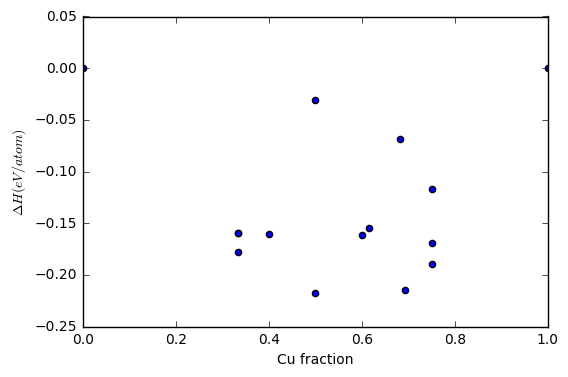

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(*zip(*points))
plt.xlim(0, 1)
plt.xlabel("Cu fraction")
plt.ylabel("$\Delta H (eV/atom)$")